# Data Exploration 

In [188]:
import numpy as np
import pandas as pd 
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Connect to Local SQL Database|

In [190]:
conn = sqlite3.connect("data/im.db")
imdb_people = pd.read_sql( 
    """
    SELECT ordering, movie_basics.start_year, movie_basics.primary_title, movie_ratings.averagerating, persons.primary_name, genres, characters, category, principals.job 
        FROM principals 
            JOIN persons
                ON principals.person_id == persons.person_id
            JOIN movie_basics 
                ON principals.movie_id == movie_basics.movie_id
            JOIN movie_ratings
                ON principals.movie_id == movie_ratings.movie_id
    """
, conn
)

#standardize column names
imdb_people = imdb_people.rename(columns={"primary_title": "title", "start_year": "year"})
imdb_people.head()

,ordering,year,title,averagerating,primary_name,genres,characters,category,job
0,10,2011,The Wicker Tree,3.9,Sean Barton,"Drama,Horror",None,editor,None
1,1,2011,The Wicker Tree,3.9,Brittania Nicol,"Drama,Horror","[""Beth Boothby""]",actress,None
2,2,2011,The Wicker Tree,3.9,Henry Garrett,"Drama,Horror","[""Steve Thomson""]",actor,None
3,3,2011,The Wicker Tree,3.9,Graham McTavish,"Drama,Horror","[""Sir Lachlan Morrison""]",actor,None
4,4,2011,The Wicker Tree,3.9,Jacqueline Leonard,"Drama,Horror","[""Lady Delia Morrison""]",actress,None


In [191]:
imdb_movies = pd.read_sql( 
    """
    SELECT movie_basics.start_year, movie_basics.primary_title, movie_ratings.averagerating, genres 
        FROM movie_basics 
            JOIN movie_ratings
                ON movie_basics.movie_id == movie_ratings.movie_id
    """
, conn
)

imdb_movies = imdb_movies.rename(columns={"primary_title": "title", "start_year": "year", "averagerating": 'imdb_rating'})
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Musical", "Music")
imdb_movies['genres'] = imdb_movies['genres'].str.replace("Sci-Fi", "Science Fiction")


imdb_movies.info()
imdb_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         73856 non-null  int64  
 1   title        73856 non-null  object 
 2   imdb_rating  73856 non-null  float64
 3   genres       73052 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


,year,title,imdb_rating,genres
0,2013,Sunghursh,7.0,"Action,Crime,Drama"
1,2019,One Day Before the Rainy Season,7.2,"Biography,Drama"
2,2018,The Other Side of the Wind,6.9,Drama
3,2018,Sabse Bada Sukh,6.1,"Comedy,Drama"
4,2017,The Wandering Soap Opera,6.5,"Comedy,Drama,Fantasy"


# CSV and TSV Imports

In [193]:
#https://www.boxofficemojo.com/
bom = pd.read_csv('data/bom.movie_gross.csv')
#https://www.themoviedb.org/
tmdb = pd.read_csv('data/tmdb.movies.csv')
#https://www.the-numbers.com/
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')
#Academy_Awards_DB_from_https://www.kaggle.com/datasets/unanimad/the-oscar-award
oscars = pd.read_csv('data/the_oscar_award.csv')

### CSV Head Checks + Basic Cleaning

We making sure each DataFrame is using a datetimes for dates and cleaning any 'unique' systems, like TMDB using a numeric code for genre. We also standardize column names. 

#### Cleaning Functions

In [197]:
def csStringToList(cs_string):
    if type(cs_string) == str:
        return cs_string.split(',')
    else:
        return cs_string
    
def money_to_int(money):
    if type(money) != str:
        return money
    if '$' in money:
        #remove cash symbol
        money = money.replace('$', '')
    money = money.replace(',', '')
    money.strip()
    return money

def move_standardize(movie):
    if type(movie) == str:
        movie = movie.replace("â", "'")
        return movie
    else: 
        return movie

Make sure the IMDB dfs are also using lists of genres.

In [199]:
imdb_movies['genres'] = imdb_movies['genres'].map(csStringToList)
imdb_people['genres'] = imdb_people['genres'].map(csStringToList)

imdb_movies['title'] = imdb_movies['title'].map(move_standardize)
imdb_people['title'] = imdb_people['title'].map(move_standardize)


## Clean BOM

In [201]:
bom = bom.rename(columns={"foreign_gross": "worldwide_gross"})
bom['domestic_gross'] = bom['domestic_gross'].map(money_to_int).astype(float)
bom['worldwide_gross'] = bom['worldwide_gross'].map(money_to_int).astype(float)
bom['title'] = bom['title'].map(move_standardize)
bom['worldwide_gross'] =  bom['worldwide_gross'] + bom['domestic_gross']
bom.info()
bom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3387 non-null   object 
 1   studio           3382 non-null   object 
 2   domestic_gross   3359 non-null   float64
 3   worldwide_gross  2009 non-null   float64
 4   year             3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


,title,studio,domestic_gross,worldwide_gross,year
0,Toy Story 3,BV,415000000.0,1.067000e+09,2010
1,Alice in Wonderland (2010),BV,334200000.0,1.025500e+09,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,9.603000e+08,2010
3,Inception,WB,292600000.0,8.283000e+08,2010
4,Shrek Forever After,P/DW,238700000.0,7.526000e+08,2010


## Clean TMDB

In [203]:
def genreIDtoGenre(id_list):
    #'comma separated' 
    cs = id_list[1:-1]
    cs.strip()
    ids = cs.split(', ')
    newlist = []
    for id in ids:
        if id == "12":
            newlist.append("Adventure")
        if id == "28":
            newlist.append("Action")
        if id == "16":
            newlist.append("Animation")
        if id == "35":
            newlist.append("Comedy")
        if id == "80":
            newlist.append("Crime")
        if id == "99":
            newlist.append("Documentary")
        if id == "18":
            newlist.append("Drama")
        if id == "10751":
            newlist.append("Family")
        if id == "14":
            newlist.append("Fantasy")
        if id == "36":
            newlist.append("History")
        if id == "27":
            newlist.append("Horror")
        if id == "10402":
            newlist.append("Music")
        if id == "9648":
            newlist.append("Mystery")
        if id == "10749":
            newlist.append("Romance")
        if id == "878":
            newlist.append("Science Fiction")
        if id == "10770":
            newlist.append("TV Movie")
        if id == "53":
            newlist.append("Thriller")
        if id == "10752":
            newlist.append("War")
        if id == "37":
            newlist.append("Western")
    return newlist

tmdb['genres'] = tmdb['genre_ids'].map(genreIDtoGenre)
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])
tmdb['title'] = tmdb['title'].map(move_standardize)

tmdb = tmdb.rename(columns={"vote_average": "tmdb_rating"})
tmdb = tmdb.drop(columns={"id", "genre_ids",  'Unnamed: 0'})

tmdb.info()
tmdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_language  26517 non-null  object        
 1   original_title     26517 non-null  object        
 2   popularity         26517 non-null  float64       
 3   release_date       26517 non-null  datetime64[ns]
 4   title              26517 non-null  object        
 5   tmdb_rating        26517 non-null  float64       
 6   vote_count         26517 non-null  int64         
 7   genres             26517 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.6+ MB


,original_language,original_title,popularity,release_date,title,tmdb_rating,vote_count,genres
0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"[Adventure, Fantasy, Family]"
1,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"[Fantasy, Adventure, Animation, Family]"
2,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"[Adventure, Action, Science Fiction]"
3,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"[Animation, Comedy, Family]"
4,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"[Action, Science Fiction, Adventure]"


### Clean TN

In [205]:
def checkUSD(money):
    money = money[0]
    if money =='$':
        return True
    else:
        return False

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(money_to_int)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(money_to_int)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(money_to_int)
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].dt.year
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].map(move_standardize)

tn_movie_budgets = tn_movie_budgets.rename(columns={"movie": "title"})

tn_movie_budgets.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017


# Creating Larger Databases

The goals are to create two main data frames. We want one to center around movie titles, studios, importaint people, production budgets, etc. The other will include genre information and public reception.

We can then merge these to have one main dataframe with the sum of our knowlegde

## Movie Data

We first merge bom and tn_movie budgets, as they are our main sources of financial data.

In [210]:
budget_info = pd.concat([tn_movie_budgets, bom])
budget_info['production_budget'] = budget_info['production_budget'].fillna(value=0)
budget_info['domestic_gross'] = budget_info['domestic_gross'].fillna(value=0)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].fillna(value=0)

budget_info['production_budget'] = budget_info['production_budget'].astype(float)
budget_info['domestic_gross'] = budget_info['domestic_gross'].astype(float)
budget_info['worldwide_gross'] = budget_info['worldwide_gross'].astype(float)

def profit_ratio(row):
    if row['production_budget'] == 0:
        return 0
    else:
        return (row['worldwide_gross'] - row['production_budget']) / row['production_budget'] * 100

budget_info['financial_ratio'] = budget_info.apply(profit_ratio, axis = 1)

#drop duplicates
budget_info = budget_info.drop_duplicates(["title", "year"])

budget_info = budget_info.drop(columns='id')

budget_info.info()
budget_info.head()


<class 'pandas.core.frame.DataFrame'>
Index: 7926 entries, 0 to 3386
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5781 non-null   datetime64[ns]
 1   title              7926 non-null   object        
 2   production_budget  7926 non-null   float64       
 3   domestic_gross     7926 non-null   float64       
 4   worldwide_gross    7926 non-null   float64       
 5   year               7926 non-null   int64         
 6   studio             2141 non-null   object        
 7   financial_ratio    7926 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 557.3+ KB


,release_date,title,production_budget,domestic_gross,worldwide_gross,year,studio,financial_ratio
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,553.257713
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,NaN,154.667286
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,-57.210757
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,NaN,324.384139
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,315.369636


We then want to merge IMBD and TMDB, which have more information on ratings.

In [212]:
#joining TMDB and IMDB on the title and year
tmdb_imdb = pd.concat([imdb_movies, tmdb])
#drop duplicates
tmdb_imdb = tmdb_imdb.drop_duplicates(["title", "release_date"])

tmdb_imdb.info()
tmdb_imdb.head()

<class 'pandas.core.frame.DataFrame'>
Index: 95483 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               69993 non-null  float64       
 1   title              95483 non-null  object        
 2   imdb_rating        69993 non-null  float64       
 3   genres             94712 non-null  object        
 4   original_language  25490 non-null  object        
 5   original_title     25490 non-null  object        
 6   popularity         25490 non-null  float64       
 7   release_date       25490 non-null  datetime64[ns]
 8   tmdb_rating        25490 non-null  float64       
 9   vote_count         25490 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 8.0+ MB


,year,title,imdb_rating,genres,original_language,original_title,popularity,release_date,tmdb_rating,vote_count
0,2013.0,Sunghursh,7.0,"[Action, Crime, Drama]",NaN,NaN,NaN,NaT,NaN,NaN
1,2019.0,One Day Before the Rainy Season,7.2,"[Biography, Drama]",NaN,NaN,NaN,NaT,NaN,NaN
2,2018.0,The Other Side of the Wind,6.9,[Drama],NaN,NaN,NaN,NaT,NaN,NaN
3,2018.0,Sabse Bada Sukh,6.1,"[Comedy, Drama]",NaN,NaN,NaN,NaT,NaN,NaN
4,2017.0,The Wandering Soap Opera,6.5,"[Comedy, Drama, Fantasy]",NaN,NaN,NaN,NaT,NaN,NaN


In [213]:
movie_db = budget_info.merge(tmdb_imdb, how='left', on=['title', 'release_date'])

#drop duplicates

movie_db['year_x'] = movie_db['year_x'].fillna(pd.to_datetime(movie_db['year_y']))
movie_db['release_date'] = movie_db['release_date'].dt.strftime('%m/%d/%Y')

#drop duplicate columns 
movie_db = movie_db.drop(columns={"year_y"})
movie_db = movie_db.rename(columns={"year_x": "year"})



movie_db.info()
movie_db.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       5781 non-null   object 
 1   title              7926 non-null   object 
 2   production_budget  7926 non-null   float64
 3   domestic_gross     7926 non-null   float64
 4   worldwide_gross    7926 non-null   float64
 5   year               7926 non-null   int64  
 6   studio             2141 non-null   object 
 7   financial_ratio    7926 non-null   float64
 8   imdb_rating        1442 non-null   float64
 9   genres             2740 non-null   object 
 10  original_language  1298 non-null   object 
 11  original_title     1298 non-null   object 
 12  popularity         1298 non-null   float64
 13  tmdb_rating        1298 non-null   float64
 14  vote_count         1298 non-null   float64
dtypes: float64(8), int64(1), object(6)
memory usage: 929.0+ KB


,release_date,title,production_budget,domestic_gross,worldwide_gross,year,studio,financial_ratio,imdb_rating,genres,original_language,original_title,popularity,tmdb_rating,vote_count
0,12/18/2009,Avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,553.257713,NaN,"[Action, Adventure, Fantasy, Science Fiction]",en,Avatar,26.526,7.4,18676.0
1,05/20/2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,NaN,154.667286,NaN,"[Adventure, Action, Fantasy]",en,Pirates of the Caribbean: On Stranger Tides,30.579,6.4,8571.0
2,06/07/2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,-57.210757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05/01/2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,NaN,324.384139,NaN,"[Action, Adventure, Science Fiction]",en,Avengers: Age of Ultron,44.383,7.3,13457.0
4,12/15/2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,315.369636,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Oscar Data Manipulation

In [215]:
# Removing rows without a film name
oscars = oscars[oscars['film'].notna()]
oscars['film'] = oscars['film'].map(move_standardize)
oscars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10570 entries, 0 to 10884
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10570 non-null  int64 
 1   year_ceremony  10570 non-null  int64 
 2   ceremony       10570 non-null  int64 
 3   category       10570 non-null  object
 4   name           10570 non-null  object
 5   film           10570 non-null  object
 6   winner         10570 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 588.4+ KB


In [216]:
#Importing a map to change awards from specific award to Major or Minor Award
oscar_categ_map = pd.read_csv('data/oscar_categ_map.csv')
oscar_categ_map.head()

,Major,Minor
0,ANIMATED FEATURE FILM,ACTOR
1,ASSISTANT DIRECTOR,ACTOR IN A LEADING ROLE
2,AWARD OF COMMENDATION,ACTOR IN A SUPPORTING ROLE
3,BEST MOTION PICTURE,ACTRESS
4,BEST PICTURE,ACTRESS IN A LEADING ROLE


In [217]:
#Creating Lists of Major and Minor Award Categories to map against the Oscar Award dataframe
major_oscars = oscar_categ_map['Major'].to_list()
minor_oscars = oscar_categ_map['Minor'].to_list()

In [218]:
def categ_major_oscar(category):
    if category in major_oscars:
        return 1

    else:
        return 0

def categ_minor_oscar(category):
    if category in major_oscars:
        return 0

    else:
        return 1


oscars['Major_Noms'] = oscars['category'].map(categ_major_oscar)
oscars['Minor_Noms'] = oscars['category'].map(categ_minor_oscar)


In [219]:
oscars['nominations'] = 1

In [220]:
oscars['Major_Win'] = 0
oscars['Minor_Win'] = 0

for index, row in oscars.iterrows():
    if row['winner'] == True:
        if row['Minor_Noms'] == 1:
            oscars.at[index, 'Minor_Win'] = 1
        else:
            oscars.at[index, 'Major_Win'] = 1

oscars[14:35]

,year_film,year_ceremony,ceremony,category,name,film,winner,Major_Noms,Minor_Noms,nominations,Major_Win,Minor_Win
14,1927,1928,1,DIRECTING (Dramatic Picture),Herbert Brenon,Sorrell and Son,False,1,0,1,0,0
15,1927,1928,1,DIRECTING (Dramatic Picture),King Vidor,The Crowd,False,1,0,1,0,0
17,1927,1928,1,ENGINEERING EFFECTS,Roy Pomeroy,Wings,True,0,1,1,0,1
19,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,The Racket,False,1,0,1,0,0
20,1927,1928,1,OUTSTANDING PICTURE,Fox,7th Heaven,False,1,0,1,0,0
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,True,1,0,1,1,0
22,1927,1928,1,UNIQUE AND ARTISTIC PICTURE,Fox,Sunrise,True,1,0,1,1,0
23,1927,1928,1,UNIQUE AND ARTISTIC PICTURE,Metro-Goldwyn-Mayer,The Crowd,False,1,0,1,0,0
24,1927,1928,1,UNIQUE AND ARTISTIC PICTURE,Paramount Famous Lasky,Chang,False,1,0,1,0,0
25,1927,1928,1,WRITING (Adaptation),Alfred Cohn,The Jazz Singer,False,1,0,1,0,0


In [221]:
oscars = oscars.groupby(['film', 'year_film']).sum().reset_index()
oscars.loc[oscars['film'] == 'Titanic']

,film,year_film,year_ceremony,ceremony,category,name,winner,Major_Noms,Minor_Noms,nominations,Major_Win,Minor_Win
4708,Titanic,1953,3908,52,ART DIRECTION (Black-and-White)WRITING (Story ...,"Art Direction: Lyle Wheeler, Maurice Ransford...",1,1,1,2,1,0
4709,Titanic,1997,27972,980,ACTRESS IN A LEADING ROLEACTRESS IN A SUPPORTI...,Kate WinsletGloria StuartArt Direction: Peter...,11,2,12,14,2,9


In [222]:
oscars = oscars.rename(columns={"year_film": "year", 'film': 'title'})
oscars.head()

,title,year,year_ceremony,ceremony,category,name,winner,Major_Noms,Minor_Noms,nominations,Major_Win,Minor_Win
0,"$1,000 a Minute",1935,1936,8,SOUND RECORDING,Republic Studio Sound Department,0,0,1,1,0,0
1,'38',1986,1987,59,FOREIGN LANGUAGE FILM,Austria,0,1,0,1,0,0
2,'Crocodile' Dundee,1986,1987,59,WRITING (Screenplay Written Directly for the S...,"Screenplay by Paul Hogan, Ken Shadie, John Cor...",0,1,0,1,0,0
3,'Round Midnight,1986,3974,118,ACTOR IN A LEADING ROLEMUSIC (Original Score),Dexter GordonHerbie Hancock,1,0,2,2,0,1
4,(A) Torzija [(A) Torsion],2003,2004,76,SHORT FILM (Live Action),Stefan Arsenijevi¿,0,1,0,1,0,0


In [223]:
movies_oscars = movie_db.merge(oscars, how='left', on=['title', 'year'])
movies_oscars.head()

,release_date,title,production_budget,domestic_gross,worldwide_gross,year,studio,financial_ratio,imdb_rating,genres,...,year_ceremony,ceremony,category,name,winner,Major_Noms,Minor_Noms,nominations,Major_Win,Minor_Win
0,12/18/2009,Avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,553.257713,NaN,"[Action, Adventure, Fantasy, Science Fiction]",...,18090.0,738.0,ART DIRECTIONCINEMATOGRAPHYDIRECTINGFILM EDITI...,Production Design: Rick Carter and Robert Stro...,3.0,2.0,7.0,9.0,0.0,3.0
1,05/20/2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,NaN,154.667286,NaN,"[Adventure, Action, Fantasy]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/07/2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,-57.210757,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05/01/2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,NaN,324.384139,NaN,"[Action, Adventure, Science Fiction]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12/15/2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,315.369636,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Breakdown By Genre

In [225]:
movie_genres = movies_oscars.explode('genres')
#movie_genres.groupby(movie_genres['genres']).mean(numeric_only=True)
movie_genres = movie_genres.drop(columns={"release_date", "title", "year", "studio", "year_ceremony", "ceremony", "category", "name", "original_language", "original_title"})
movie_genres = movie_genres.groupby(movie_genres['genres'])

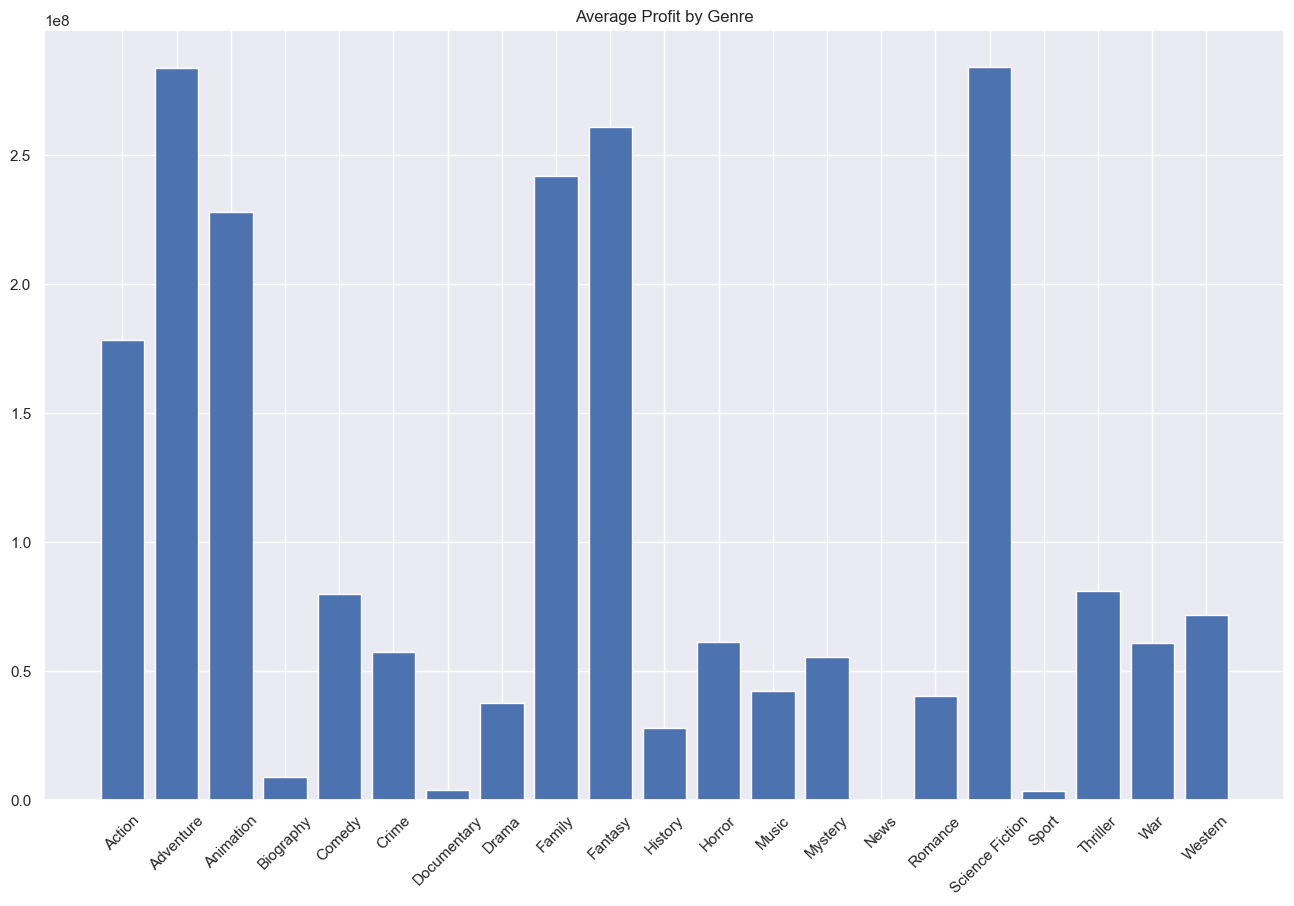

In [226]:
#accidents per year
fig, ax = plt.subplots(figsize=(16, 10))

genres = [genre for genre, df in movie_genres]
x = genres

worldwide_gross = movie_genres['worldwide_gross']
y = list(worldwide_gross.mean().values)

genres_figure_df = pd.DataFrame(
    {
        'Genre': genres,
        'Global Profit': worldwide_gross
    }
)

ax.bar(x, y)
ax.set_title("Average Profit by Genre")
ax.set_xticklabels(x, rotation=45);

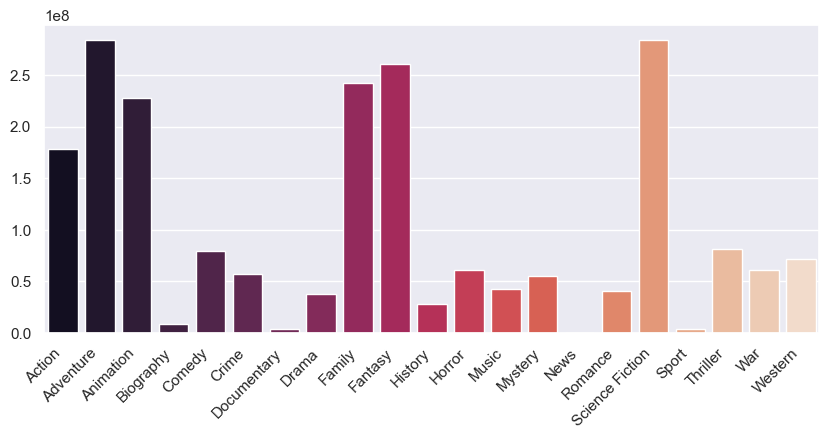

In [227]:
sns.set_theme()


plt.figure(figsize=(10,4))
genre_plot = sns.barplot(x=x, y=y, palette="rocket")
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=45, ha="right");

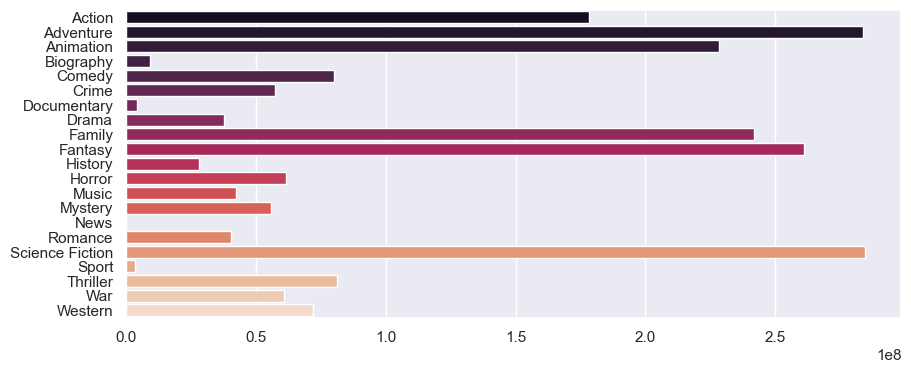

In [228]:
sns.set_theme()


plt.figure(figsize=(10,4))
sns.barplot(x=y, y=x, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
genres_figure_df;

### Weighted Movie Quality Rating

In [230]:
# Function to calculate average rating
def calculate_avg_rating(row):
    if pd.isna(row['imdb_rating']) and pd.isna(row['tmdb_rating']):
        return np.nan
    elif pd.isna(row['imdb_rating']):
        return row['tmdb_rating']
    elif pd.isna(row['tmdb_rating']):
        return row['imdb_rating']
    else:
        return (row['imdb_rating'] + row['tmdb_rating']) / 2

# Apply the function to each row
movies_oscars['avg_rating'] = movies_oscars.apply(calculate_avg_rating, axis=1)

In [231]:
movies_oscars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7926 entries, 0 to 7925
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       5781 non-null   object 
 1   title              7926 non-null   object 
 2   production_budget  7926 non-null   float64
 3   domestic_gross     7926 non-null   float64
 4   worldwide_gross    7926 non-null   float64
 5   year               7926 non-null   int64  
 6   studio             2141 non-null   object 
 7   financial_ratio    7926 non-null   float64
 8   imdb_rating        1442 non-null   float64
 9   genres             2740 non-null   object 
 10  original_language  1298 non-null   object 
 11  original_title     1298 non-null   object 
 12  popularity         1298 non-null   float64
 13  tmdb_rating        1298 non-null   float64
 14  vote_count         1298 non-null   float64
 15  year_ceremony      1002 non-null   float64
 16  ceremony           1002 

In [232]:
movies_oscars['avg_rating'].value_counts().sort_index()

avg_rating
1.6    1
1.7    1
2.4    1
2.5    1
2.6    3
      ..
8.6    1
8.7    2
8.8    1
8.9    1
9.0    1
Name: count, Length: 67, dtype: int64

In [233]:
weighted_ratings = movies_oscars.loc[movies_oscars['category'].notnull()]

In [234]:
weighted_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 7829
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       938 non-null    object 
 1   title              1002 non-null   object 
 2   production_budget  1002 non-null   float64
 3   domestic_gross     1002 non-null   float64
 4   worldwide_gross    1002 non-null   float64
 5   year               1002 non-null   int64  
 6   studio             63 non-null     object 
 7   financial_ratio    1002 non-null   float64
 8   imdb_rating        56 non-null     float64
 9   genres             261 non-null    object 
 10  original_language  205 non-null    object 
 11  original_title     205 non-null    object 
 12  popularity         205 non-null    float64
 13  tmdb_rating        205 non-null    float64
 14  vote_count         205 non-null    float64
 15  year_ceremony      1002 non-null   float64
 16  ceremony           1002 non-n

In [235]:
movies_oscars.to_csv('data/movies_oscars.csv')

In [236]:
tmdb.to_csv('data/tmdb_clean.csv')

In [237]:
imdb_movies.to_csv('data/imdb_movies.csv')
imdb_people.to_csv('data/imdb_people.csv')

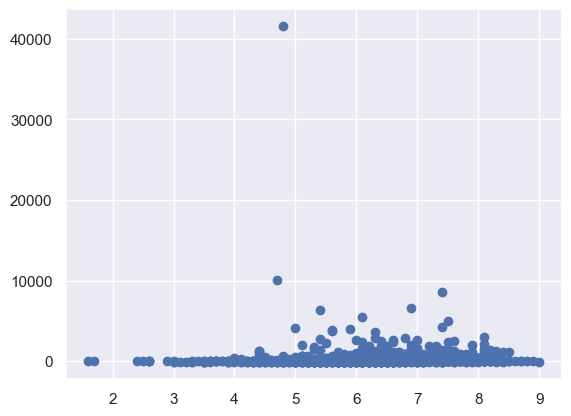

In [238]:
fig, ax = plt.subplots()

ax.scatter(movies_oscars['avg_rating'], movies_oscars['financial_ratio'])

In [282]:
movies_oscars['financial_ratio'].sort_values(ascending=False)[0:20]

5744    179900.000000
5612     49775.000000
5491     43051.785333
5678     41556.474000
5406     41283.333333
5708     34105.858462
5346     31135.431235
5772     29070.400000
5675     26292.161404
5210     22400.000000
5535     21438.461538
5714     20753.012000
5664     18880.313571
5372     17918.018018
5780     16358.272727
5655     15449.087333
5741     14323.111111
5611     12400.000000
5117     12327.788038
5357     12150.000000
Name: financial_ratio, dtype: float64

In [288]:
movies_oscars['financial_ratio'].isna().value_counts()

financial_ratio
False    7926
Name: count, dtype: int64

In [290]:
mov_osc_fin = movies_oscars.loc[(movies_oscars['production_budget'] > 0) & (movies_oscars['worldwide_gross'] > 0)]

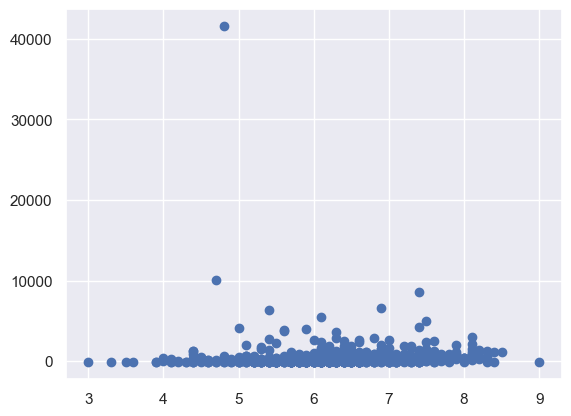

In [292]:
fig, ax = plt.subplots()

ax.scatter(mov_osc_fin['avg_rating'], mov_osc_fin['financial_ratio'])